Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Vector Similarity Algorithms

Vector similarity algorithms work by using vector based representations of data, a.k.a. embeddings, to answer questions about the data's context and its similarity and connection to other data.

For example, a support agent could translate a question that they receive into a vector and use it to search the support knowledge base for articles that are similar to the words in the question (implicit similarity). For the most applicable articles, they could then collect metadata about the author, previous cases, runbooks, and so on so as to provide additional context when answering the question (explicit data).

A Bioinformatics researcher, who is interested in re-purposing existing blood pressure drugs for other treatable diseases, may want to use vector similarity search over in-house knowledge graphs to find patterns in protein interaction networks.

For another example, a large online book retailer may need to use known pirated material to quickly identify similar media in conjunction with a knowledge graph to identify patterns of deceptive listing behaviours and find malicious sellers.

In both cases, vector search over a knowledge graph increases accuracy and speed when building the solution. In comparison to other tools available today, it provides reduced operational overhead and complexity.

## Supported Algorithms

Neptune Analytics supports the following vector similarity algorithms:

* [Manage an Embedding](#Manage-an-Embedding) -  This set of algorithms manages the stored embedding for a node
* [Distance](#Distance) -  This algorithm computes the distance between two vectors based on their embeddings. The distance is the L2 norm of the vectors.
* [topK](#TopK) -   This algorithm finds the topK nearest neighbors of an embedding based either on an embedding or by comparing against a node.

## Creating the Graph

To use this dataset, you need to create a graph that has a vector search index with a dimension of 1536.  This step must be completed prior to running the following load commands.  

This can be done using a command similar to the one below, which can be run from a client that has the AWS CLI configured and appropriate permissions.  Please refer to the [documentation](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/vector-similarity.html) for the details on setting up a vector search enabled graph.

```
aws neptune-graph create-graph --graph-name 'air-routes-embeddings' --provisioned-memory 128 --public-connectivity --replica-count 0 --vector-search-configuration '{"dimension": 1536}'
```
    
## Loading Data
The first step in most projects is to load data to use for analysis.  For demonstration purposes, we have provided a set of datasets that can be used to demonstrate the features and functionality of Neptune Analytics. 

The cell below makes it easy to load a modified version of the `air-routes` data into your graph.  The `air-routes` dataset we will be loading in this notebook is supplied as part of the [Practical Gremlin](https://kelvinlawrence.net/book/Gremlin-Graph-Guide.html#air) book.

The `air-route` graph contains several vertex types that are specified using labels. The most common ones being `airport` and `country`. There are also nodes for each of the seven continents (`continent`), in addition to a single `version` vertex that I provided as a way to test which version of the graph you are using.

Routes between airports are modeled as edges. These edges carry the `route` label and include the distance between the two connected airport vertices as a property called `dist`. Connections between countries and airports are modelled using an edge with a `contains` label.

Each `airport` vertex has many properties associated with it giving various details about the airport, including its IATA and ICAO codes, its description, the city it is in, and its geographic location.

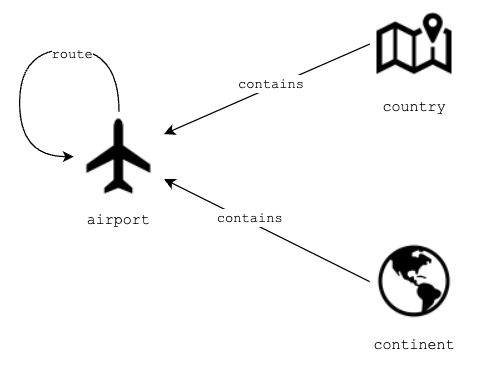

In addition to the properties of the `air-routes` dataset, the modified version used for this notebook also contains a vector embedding of a JSON version of the node properties.  This was accomplished using [LangChain](https://python.langchain.com/docs/get_started/introduction) and [Amazon Bedrock's Titan Text Embedding](https://docs.aws.amazon.com/bedrock/latest/userguide/embeddings.html) model, as shown in the code snippet below.

```
import boto3
from langchain.embeddings import BedrockEmbeddings
import pandas as pd

df = pd.read_csv("air-routes-latest-nodes.csv")
bedrock_client = boto3.client(service_name="bedrock-runtime", region_name="<INSERT REGION>")
bedrock_embeddings = BedrockEmbeddings(
    model_id="amazon.titan-embed-text-v1", client=bedrock_client
)
for i in df.index:
    if df.loc[i]["~label"] == "airport":
        json = df.loc[i].to_json()
        embedding = bedrock_embeddings.embed_query(json)
        df.at[i, "embedding:vector"] = (
            str(embedding).replace(", ", ";").replace("[", "").replace("]", "")
        )
    if i % 25 == 0:
        print(f"Embedding row {i}")


df.to_csv("air-routes-latest-nodes.csv", index=False)
```

To load this dataset, run the two cells below.  This first cell will setup a few python variables using the configuration parameters of this Neptune Notebook.  The second cell will use Neptune Analytics' batch load feature to load the data from the provided S3 bucket.  

**Note:** You only need to do this once. If you have already loaded the data previously, you do not need to load it again.

In [ ]:
import graph_notebook as gn
config = gn.configuration.get_config.get_config()

s3_bucket = f"s3://aws-neptune-customer-samples-{config.aws_region}/sample-datasets/gremlin/air-routes-with-embeddings/"
region = config.aws_region

In [ ]:
%%oc 

CALL neptune.load({format: "csv", 
                   source: "${s3_bucket}", 
                   region : "${region}"})

## Manage an Embedding

In Neptune Analytics, the embedding for each node is stored as a kind of "hidden" property that is not returned using standard openCypher.  To manage these embeddings, we provide several algorithms to perform standard CRUD operations:

- `neptune.algo.vectors.get`: This will retrieve and return the specified node's embedding.

- `neptune.algo.vectors.upsert`: This will update or insert the provided embedding to the specified node.

- `neptune.algo.vectors.remove`: This will remove the specified node's embedding.

These algorithms can be combined with other openCypher clauses to perform more complex patterns, such as upserting a node with an externally generated embedding at the time of creation.

Using our air routes data, let's show how to return the embeddings of both the Seattle and Anchorage airports.

In [ ]:
%%oc

MATCH (n) 
WHERE n.code in ['SEA', 'ANC']
CALL neptune.algo.vectors.get(n)
YIELD node, embedding
RETURN n.code, embedding

## Distance

Vector distance is an algorithm that computes the distance between two vectors based on their embeddings. The distance is calculated from the L2 norm of the vectors and can represent the similarity or dissimilarity of the entities.


Here are some common uses of vector similarity distance algorithms:

- Document/Description similarity/plagiarism detection. Comparing the vector representations of documents to find similar or duplicate content. Algorithms like SBERT may be used to generate a document embedding for comparison.

- Recommender systems. Calculating the similarity between user/item vectors to recommend content the user may like. This includes uses like movie, product, or article recommendations.

- Semantic search. Mapping words/documents to vectors and using similarity measures to return semantically similar search results compared to just text match.

- Deduplication. Identifying duplicates in datasets by comparing vectors and finding entries with high similarity scores. Helps remove redundant data.

- Anomaly detection. Identifying outliers by comparing vector deviations against expected distributions. Used for fraud or anomaly detection in finance, networks, etc.

In general, vector similarity algorithms leverage distance comparisons in the high-dimensional vector space to understand how related or distinguishable data points are from each other. Choosing the appropriate similarity algorithm depends on the use case and data type.


Using our air routes data, let's find the similarity distance between the Anchorage (AK) airport and Fairbanks (AK) and Seattle (WA) airports.  When looking at the results, the smaller the distance, the more similar the two nodes are.

In [ ]:
%%oc

MATCH (n {code: 'ANC'}) 
MATCH (m) WHERE m.code in ['SEA', 'FAI'] 
CALL neptune.algo.vectors.distance(n, m)
YIELD distance
RETURN n.code, m.code, distance

As we see from the results, the Fairbanks airport is more similar to the Anchorage airport, which makes sense as they are both located in Alaska and have similar characteristics in their properties.

## TopK 

TopK is a vector similarity algorithm that finds the topK nearest neighbors of a node based on the distance of their vector embeddings from a comparison embedding.  In Neptune Analytics, the comparison embedding can either be provided directly using the `neptune.algos.vectors.topKByEmbedding()` algorithm, or from an input node `neptune.algos.vectors.topKByNode()`


Some common uses of vector similarity topK algorithms:

1. Recommender systems - Finding the most similar items to recommend based on a user's interests or purchase history. TopK allows recommending the most relevant items.

2. Document retrieval - Retrieving the most similar documents to a query document from a corpus. This allows finding documents on the same topic.

3. Deduplication - Identifying duplicate or near-duplicate documents in a large collection by finding those with the greatest vector similarity.

4. Semantic search - Finding documents that are semantically similar to a query, even if they don't contain the exact keywords. The vector similarities allow searching by meaning and concepts.

5. Content-based image retrieval - Finding visually similar images in a database to a query image. The vector similarities capture visual features to find images depicting similar content.

6. Fraud/anomaly detection - Identifying anomalous data points that have low vector similarity to normal data points can help detect fraud or outliers.

So in summary, vector similarity topK algorithms are very useful for finding the closest semantic "neighbors" to queries in order to improve search, recommendations, retrieval, etc. Computing top similarities allows focusing only on the most relevant data.

Using our air routes data, let's find the topK most similar nodes to the Anchorage airport.  Let's first start by fetching the embedding for the Anchorage airport and saving that as a Python variable

In [ ]:
%%oc --store-to res --silent

MATCH ( n:airport {code: 'ANC'} ) 
CALL neptune.algo.vectors.get(n) YIELD embedding
RETURN embedding

We can now see that we successfully retrieved the embedding by printing the length of the returned embedding, which is represented a list of floats.

In [ ]:
embedding = res['results'][0]['embedding']
print(len(embedding))

Now that we have an embedding, let's retrieve the topK most similar nodes to this embedding.

In [ ]:
%%oc

CALL neptune.algo.vectors.topKByEmbedding(
  ${embedding}
)
YIELD node, score
RETURN node.code, node.desc, score

As expected, the top result returned is the Anchorage airport, which makes sense given that the embedding passed in was that of the Anchorage airport.  Looking at the score, we also see that value is ~0.  When looking at similarity scores, the lower the value, the more similar the two items are.

In this example, we retrieved an embedding and then used that as the input.  In most situations, you should use the `topKByEmbedding` algorithm only when you have an externally provided embedding that you want to compare against. If you want to compare against an embedding inside the graph, you should instead use the `topKByNode` algorithm.  With this algorithm, we can find input nodes using openCypher, then pass that into the algorithm as input.  

Using this approach, let's find the topK most similar nodes to the Anchorage airport.

In [ ]:
%%oc

MATCH ( n:airport {code: 'ANC'} ) 
CALL neptune.algo.vectors.topKByNode(n)
YIELD node, score
RETURN node.code, node.desc, score

Comparing the results, we see that we get back the same topK most similar airports.

## Next Steps
In this notebook, we have demonstrated how to use the vector similarity algorithms provided by Neptune Analytics.  If you are interested in the other types of algorithms offered, please look at the other notebooks available:

* [Path finding algorithms](./02-Path-Finding-Algorithms.ipynb)

* [Centrality algorithms](./03-Centrality-Algorithms.ipynb)

* [Community Detection algorithms](./04-Community-Detection-Algorithms.ipynb)

* [Similarity algorithms](./05-Similarity-Algorithms.ipynb)